In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../core/')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import cartopy.crs as ccrs
from scipy.interpolate import RegularGridInterpolator, InterpolatedUnivariateSpline, UnivariateSpline, splev, splrep
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
import healpy as hp
from settings import *
from matplotlib.lines import Line2D
from copy import deepcopy
from tools import *
from tools import _trans

### First, get all effective areas (calculated in alternative_plenum_aeff.ipynb)

In [3]:
with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(ra_mids), "RA bins")

40 log_10(energy) bins
50 declination bins
100 RA bins


## Get the detection efficiencies as a function of sin(dec) based on the calculation in plenum_skymap_illustrations.ipynb

In [4]:
with open("../resources/detection_efficiencies.pckl", "rb") as f:
    det_eff, padded_sd = pickle.load(f)

### get the current discovery potential

In [5]:
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
gamma = 2.5
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
gamma = 3.0
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
### result from 7yr analysis, if wanted
disc_7yr = np.genfromtxt('../resources/PSdiscPot7years.csv', delimiter=',')
sdec_7yr = disc_7yr[:,0]
disc_7yr = disc_7yr[:,1]

for gamma in ps_disc:
    ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
    xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
    ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
    spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

reference_ddecs = np.array([-40, 0, 40])
reference_sdecs = np.sin(np.deg2rad(reference_ddecs))

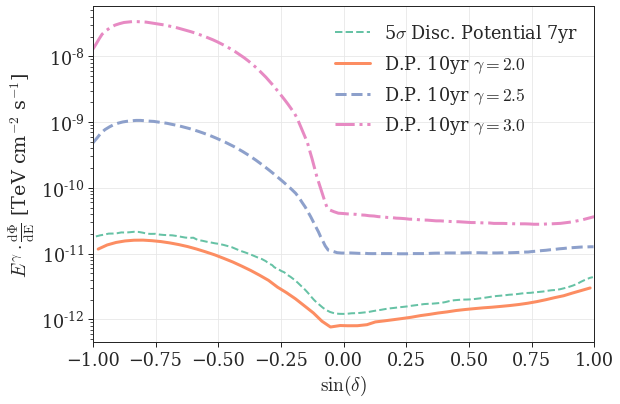

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(sdec_7yr, disc_7yr, ls='--', label="5$\sigma$ Disc. Potential 7yr")
gamma = 2.0 
ax.plot(xsd[gamma], ic_10yr[gamma], ls='-', lw=3, label=fr'D.P. 10yr $\gamma={gamma}$')
gamma = 2.5
ax.plot(xsd[gamma], ic_10yr[gamma], ls='--', lw=3, label=fr'D.P. 10yr $\gamma={gamma}$')
gamma = 3.0
ax.plot(xsd[gamma], ic_10yr[gamma], ls='-.', lw=3, label=fr'D.P. 10yr $\gamma={gamma}$')

ax.legend(loc='upper right', ncol=1, frameon=False)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^{\gamma} \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
fig.tight_layout()


### Idea:
* Discovery potential improvement for same time -> translated from scaling in effective area

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8} \equiv \left( \frac{\epsilon_{\rm new}}{\epsilon_{\rm IC}} \right)^{0.8}$

$\Rightarrow \Phi_{\rm new} = \frac{\Phi_{IC}}{R} = \Phi_{IC} \cdot \left( \frac{\epsilon_{\rm IC}}{\epsilon_{\rm new}} \right)^{0.8}$ (with detection efficiency = $\epsilon$)

* Alternative: adding known discovery potentials via
$ \Phi_{add} = \Phi_0 \oplus \Phi_1  := \left( \Phi_0^{-1/0.8} + \Phi_1^{-1/0.8} \right)^{-0.8} $

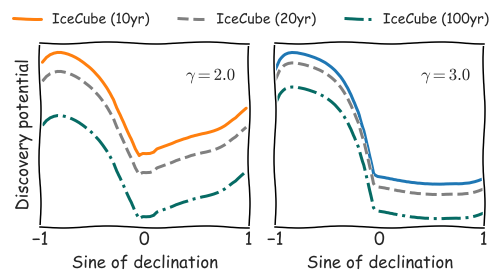

In [11]:
### simple sketchy plot as teaser
with plt.xkcd():
    f, axes = plt.subplots(ncols=2, figsize=(7, 4))
    gamma= 2.0
    ax = axes[0]

    ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
    ic_50yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.2 ** 0.8) # double time from 10yr baseline to 50yr
    ic_100yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.1 ** 0.8) # double time from 10yr baseline to 100yr
    
    ax.plot(xsd[gamma], ic_10yr[gamma], color="tab:orange", ls="-", lw=3, label=r'IceCube (10yr)')
    ax.plot(xsd[gamma], ic_20yr, color="gray", ls="--", lw=3, label=r'IceCube (20yr)')
    #ax.plot(xsd[gamma], ic_50yr, color=colors[1], ls="-", lw=3, label=r'IceCube (50yr)')
    ax.plot(xsd[gamma], ic_100yr, color=colors[2], ls="-.", lw=3, label=r'IceCube (100yr)')

    ax.set_xlabel("Sine of declination", fontsize="large")
    ax.set_yscale('log')
    ax.set_yticks([])
    ax.set_xlim(-1, 1)
    ax.text(0.7, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
    ax.set_ylabel(r"Discovery potential", fontsize="large")
    ax.tick_params(axis='both', which='both', length=0)
    f.legend(loc='upper center', ncol=3, frameon=False, fontsize="medium")


    gamma = 3.0
    ax = axes[1]
    ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
    ic_50yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.2 ** 0.8) # double time from 10yr baseline to 50yr
    ic_100yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.1 ** 0.8) # double time from 10yr baseline to 100yr
    
    ax.plot(xsd[gamma], ic_10yr[gamma], color="tab:blue", ls="-", lw=3, label=r'IceCube (10yr)')
    ax.plot(xsd[gamma], ic_20yr, color="gray", ls="--", lw=3) #, label=r'IceCube (20yr)')
    #ax.plot(xsd[gamma], ic_50yr, color=colors[1], ls="-", lw=3) #, label=r'IceCube (50yr)')
    ax.plot(xsd[gamma], ic_100yr, color=colors[2], ls="-.", lw=3) #, label=r'IceCube (100yr)')

    ax.set_xlabel("Sine of declination", fontsize="large")
    ax.set_yscale('log')
    ax.set_yticks([])
    ax.set_xlim(-1, 1)
    ax.text(0.7, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
    ax.tick_params(axis='both', which='both', length=0)
    f.tight_layout()
    plt.subplots_adjust(top = 0.85)
    f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_sketch.pdf', bbox_inches="tight")

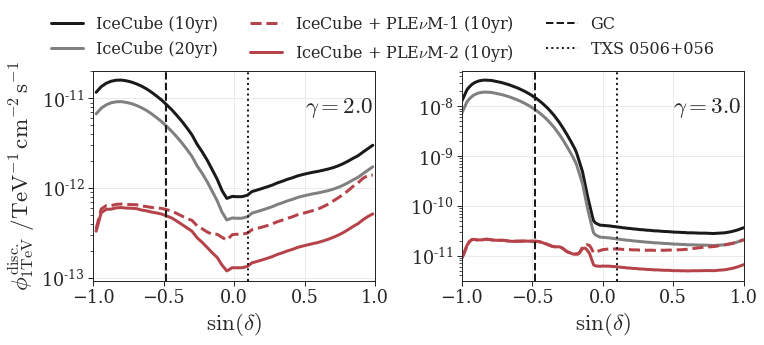

In [10]:
f, axes = plt.subplots(ncols=2, figsize=(11, 5))
ic_20yr = {}
gamma= 2.0
ax = axes[0]

ic_20yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum-1 10yr
plenum1 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-1"](xsd[gamma]))* 0.8)
# plenum-2 10yr
plenum2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-2"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum-1 (with icecube)
ic_plenum1 = (ic_10yr[gamma] ** (-1/0.8) + plenum1 ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum-2 (with gen2)
ic_plenum2 = (ic_10yr[gamma] ** (-1/0.8) + plenum2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3

ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum1 * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd[gamma], ic_plenum2 * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
ax.tick_params(axis='both', which='major')
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs.icrs.dec), ls=":", color="k", label="TXS 0506+056")
#ax.text(0.25, 0.055, "GC", transform=ax.transAxes, fontsize="small")
#ax.text(0.5, 0.055, "TXS 0506+056", transform=ax.transAxes, fontsize="small")
f.legend(loc='upper center', ncol=3, frameon=False, fontsize="small")


gamma = 3.0
ax = axes[1]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

ic_20yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum-1 10yr
plenum1 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-1"](xsd[gamma]))* 0.8)
# plenum-2 10yr
plenum2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-2"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum-1 (with icecube)
ic_plenum1 = (ic_10yr[gamma] ** (-1/0.8) + plenum1 ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum-2 (with gen2)
ic_plenum2 = (ic_10yr[gamma] ** (-1/0.8) + plenum2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3

ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr[gamma] * const, color="gray", ls="-", lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum1 * const, color=colors[3], ls="--", lw=3, label=r'IceCube + PLE$\nu$M-1 (10yr)')
ax.plot(
    xsd[gamma], ic_plenum2 * const, color=colors[3], lw=3, label=r'IceCube + PLE$\nu$M-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large" ,
         transform = ax.transAxes)
ax.tick_params(axis='both', which='major')
# add the location of the galactic center and TXS
ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", label="GC")
ax.axvline(np.sin(txs.icrs.dec), ls=":", color="k", label="TXS 0506+056")

f.tight_layout()
plt.subplots_adjust(top = 0.8)
f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_gamma20-25_woDots.pdf', bbox_inches="tight")

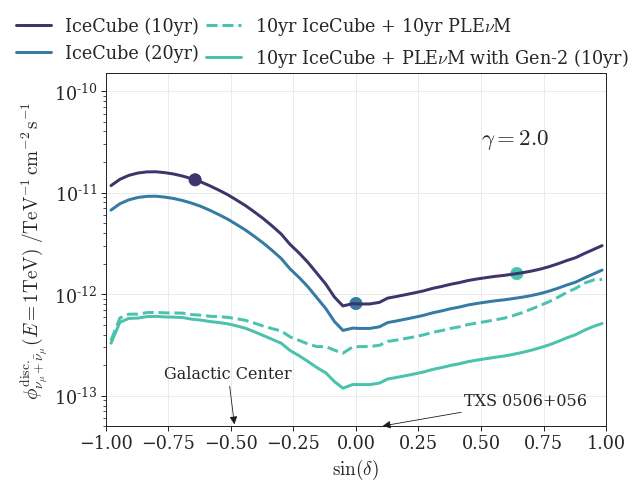

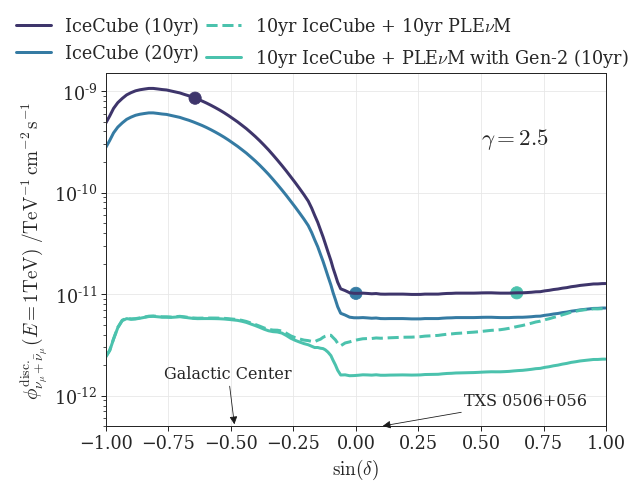

In [11]:
gamma= 2.0

ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3

f, ax = plt.subplots(figsize=(9, 7))
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')

ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=ccref[:3],
    s=150,
    alpha=1
)
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
#ax.set_ylabel(r"$\frac{{\rm d}\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")

ax.tick_params(axis='both', which='major')
ax.set_ylim(5e-14, 1.5e-10) 
# add the location of the galactic center and TXS
ax.annotate(
    "Galactic Center",
    xy=(np.sin(np.radians(-29.)), 5.e-14), xytext=(np.sin(np.radians(-50.)), 15.e-14),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small"
)

ax.annotate(
    "TXS 0506+056",
    xy=(np.sin(np.radians(5.7)), 5.e-14), xytext=(np.sin(np.radians(25.7)), 8.e-14),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small"
)
### Need to find that data ...
# km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_cascade_discPot_3years.csv', 
#                            delimiter=',')
# ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
#        ls='dotted')
# km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_track_discPot_3years.csv', 
#                            delimiter=',')
# ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
#        ls='dashed')
f.tight_layout()
plt.subplots_adjust(top = 0.85)
f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_gamma{gamma}.pdf', bbox_inches="tight")

gamma= 2.5
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3


ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8


f, ax = plt.subplots(figsize=(9, 7))
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')

ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=ccref[:3],
    s=150,
    alpha=1
)
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend(loc='upper center', mode='expand', ncol=2, frameon=False)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large" ,
         transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.tick_params(axis='both', which='major')
ax.set_ylim(5e-13, 1.5e-9) 
# add the location of the galactic center and TXS
ax.annotate(
    "Galactic Center", 
    xy=(np.sin(np.radians(-29.)), 5.e-13), xytext=(np.sin(np.radians(-50.)), 15.e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"), 
    fontsize="small"
)
ax.annotate(
    "TXS 0506+056", 
    xy=(np.sin(np.radians(5.7)), 5.e-13), xytext=(np.sin(np.radians(25.7)), 8.e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"), 
    fontsize="small"
)

f.tight_layout()
plt.subplots_adjust(top = 0.85)
f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_gamma{gamma}.pdf', bbox_inches="tight")

## put into one figure

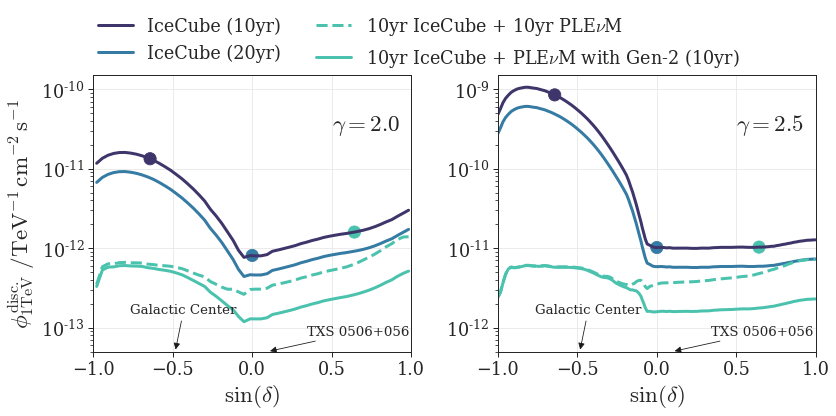

In [12]:
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

gamma= 2.0
ax = axes[0]

ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3

ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=ccref[:3],
    s=150,
    alpha=1
)
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center',
    #ncol=4, 
    ncol=2, 
    frameon=False
)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")
#ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$", fontsize="large")

ax.tick_params(axis='both', which='major')
ax.set_ylim(5e-14, 1.5e-10) 
# add the location of the galactic center and TXS
ax.annotate(
    "Galactic Center",
    xy=(np.sin(np.radians(-29.)), 5.e-14), xytext=(np.sin(np.radians(-50.)), 15.e-14),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="x-small"
)

ax.annotate(
    "TXS 0506+056",
    xy=(np.sin(np.radians(5.7)), 5.e-14), xytext=(np.sin(np.radians(20)), 8.e-14),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="x-small"
)

gamma= 2.5
ax = axes[1]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=ccref[:3],
    s=150,
    alpha=1
)
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$', fontsize="large")
ax.set_yscale('log')
ax.set_xlim(-1, 1)

ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large" ,
         transform = ax.transAxes)
ax.tick_params(axis='both', which='major')
ax.set_ylim(5e-13, 1.5e-9) 
# add the location of the galactic center and TXS
ax.annotate(
    "Galactic Center", 
    xy=(np.sin(np.radians(-29.)), 5.e-13), xytext=(np.sin(np.radians(-50.)), 15.e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"), 
    fontsize="x-small"
)
ax.annotate(
    "TXS 0506+056", 
    xy=(np.sin(np.radians(5.7)), 5.e-13), xytext=(np.sin(np.radians(20)), 8.e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"), 
    fontsize="x-small"
)

f.tight_layout()
plt.subplots_adjust(top = 0.82)
f.savefig(f'../plots/PLENUM_ps_disc_pot_comparison_gamma20-25.pdf', bbox_inches="tight")

### Make a time evolution plot for the selected declinations

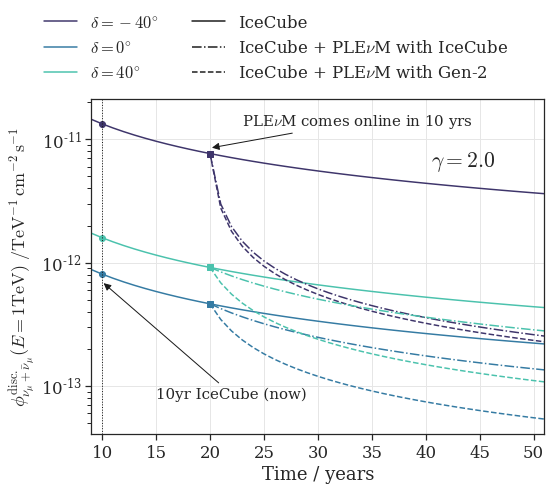

In [45]:
gamma = 2.0
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}^{{\circ}}$", color=cgen[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=cgen[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=cgen[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=cgen[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=cgen[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.axvline(10, ls=":", lw=1, color="k")
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large" ,
         transform = ax.transAxes)
ax.annotate(
    "10yr IceCube (now)",
    xy=(10, 7.e-13), xytext=(15, 0.8e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.annotate(
    r"PLE$\nu$M comes online in 10 yrs",
    xy=(20, 0.85e-11), xytext=(23, 1.3e-11),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.set_xlim(9, 51)
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)
fig.savefig(f'../plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf', bbox_inches="tight")

## same plot, but gamma=2.5

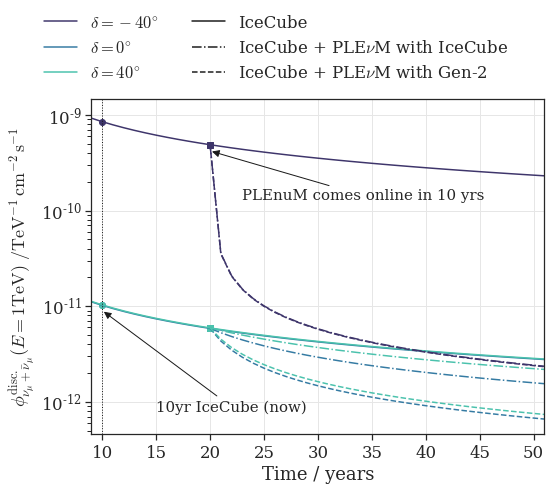

In [46]:
gamma = 2.5
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}^{{\circ}}$", color=cgen[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=cgen[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=cgen[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=cgen[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=cgen[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate(
    "10yr IceCube (now)",
    xy=(10, 9.e-12), xytext=(15, 0.8e-12),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.annotate(
    "PLEnuM comes online in 10 yrs",
    xy=(20, 4.2e-10), xytext=(23, 1.3e-10),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small")
ax.set_xlim(9, 51)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)
fig.savefig(f'../plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf', bbox_inches="tight")

## same for sensitivity

In [47]:
ps_sens = dict()
ind_sens = dict()
xsd_sens = dict()
ic_10yr_sens = dict()
spl_10yr_sens = dict()

gamma = 2.0
ps_sens[gamma] = np.genfromtxt('../resources/sens_10yr_gamma-2.txt', delimiter=' ')
ind_sens[gamma] = np.argsort(ps_sens[gamma][:,0])
xsd_sens[gamma] = ps_sens[gamma][:,0][ind_sens[gamma] ]
ic_10yr_sens[gamma] = ps_sens[gamma][:,1][ind_sens[gamma] ]
spl_10yr_sens[gamma] = splrep(xsd_sens[gamma], ic_10yr_sens[gamma])

gamma = 3.0
ps_sens[gamma] = np.genfromtxt('../resources/sens_10yr_gamma-3.txt', delimiter=' ')
ind_sens[gamma] = np.argsort(ps_sens[gamma][:,0])
xsd_sens[gamma] = ps_sens[gamma][:,0][ind_sens[gamma] ]
ic_10yr_sens[gamma] = ps_sens[gamma][:,1][ind_sens[gamma] ]
spl_10yr_sens[gamma] = splrep(xsd_sens[gamma], ic_10yr_sens[gamma])

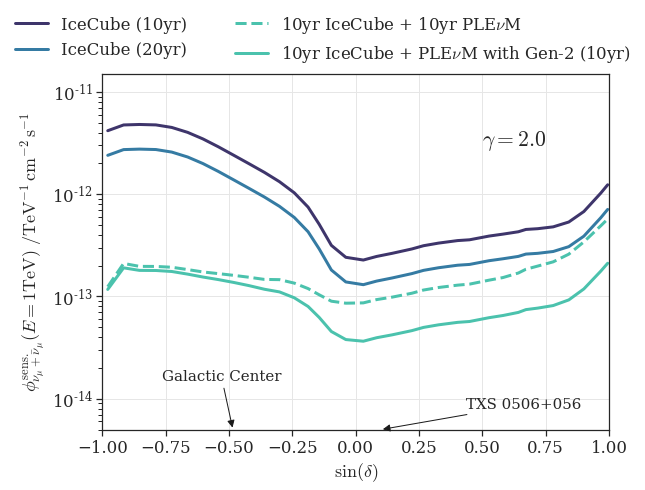

In [61]:
gamma= 2.0

ic_20yr = ps_sens[gamma][:,1][ind_sens[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Gen-2"](xsd_sens[gamma]))* 0.8)
# plenum 10yr
plenum = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Plenum"](xsd_sens[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr_sens[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3

f, ax = plt.subplots(figsize=(9, 7))
ax.plot(
    xsd_sens[gamma], ic_10yr_sens[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)'
)
ax.plot(
    xsd_sens[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd_sens[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd_sens[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{sens.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.tick_params(axis='both', which='major')
ax.set_ylim(5e-15, 1.5e-11) 
# add the location of the galactic center and TXS
ax.annotate(
    "Galactic Center",
    xy=(np.sin(np.radians(-29.)), 5.e-15), xytext=(np.sin(np.radians(-50.)), 15.e-15),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small"
)
ax.annotate(
    "TXS 0506+056",
    xy=(np.sin(np.radians(5.7)), 5.e-15), xytext=(np.sin(np.radians(25.7)), 8.e-15),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small"
)
f.tight_layout()
plt.subplots_adjust(top = 0.85)
f.savefig(f'../plots/PLENUM_ps_sens_comparison_gamma{gamma}.pdf', bbox_inches="tight")

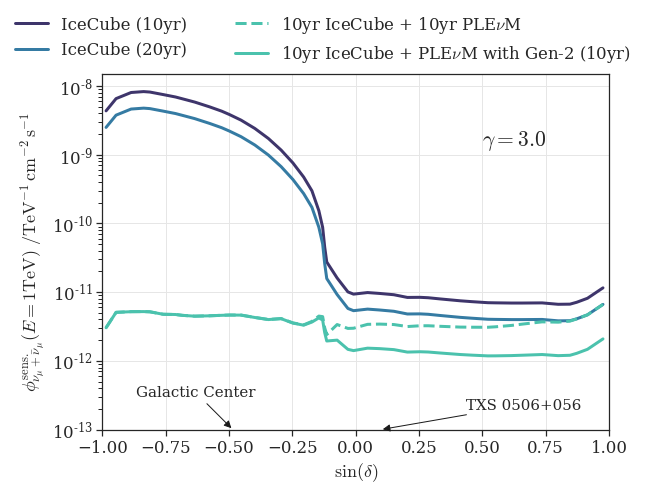

In [66]:
gamma= 3.0

ic_20yr = ps_sens[gamma][:,1][ind_sens[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Gen-2"](xsd_sens[gamma]))* 0.8)
# plenum 10yr
plenum = ps_sens[gamma][:,1][ind_sens[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd_sens[gamma]) - det_eff[gamma]["Plenum"](xsd_sens[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr_sens[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1 #  10**(-2*gamma) / 1.e3

f, ax = plt.subplots(figsize=(9, 7))
ax.plot(
    xsd_sens[gamma], ic_10yr_sens[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)'
)
ax.plot(
    xsd_sens[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd_sens[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd_sens[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75, 0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize="large", transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{sens.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.tick_params(axis='both', which='major')
ax.set_ylim(1e-13, 1.5e-8) 
# add the location of the galactic center and TXS
ax.annotate(
    "Galactic Center",
    xy=(np.sin(np.radians(-29.)), 1.e-13), xytext=(np.sin(np.radians(-60.)), 3.e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small"
)
ax.annotate(
    "TXS 0506+056",
    xy=(np.sin(np.radians(5.7)), 1.e-13), xytext=(np.sin(np.radians(25.7)), 2.e-13),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="small"
)
f.tight_layout()
plt.subplots_adjust(top = 0.85)
f.savefig(f'../plots/PLENUM_ps_sens_comparison_gamma{gamma}.pdf', bbox_inches="tight")